### Noise-contrastive estimation: A new estimation principle for unnormalized statistical models
---
Guntmann states that say we want to model some complex solution using statistical models. For high dimensionality problems it is close to impossible to calculate them. And to calculate them we need to compute the integral of the Probability Density Function (PDF). Even if we manage to find the the PDF it is hard to impossible to find its integral due to complexity.

One of examples is using Energy Based models or multi-layer networks, which reference Neural Networks. They can be considered as one of the examples of PDF that can solve and model very complex tasks. It is both impossible to compute the integral of the Network because of its high complexity and computationally very expensive as well, say by using Softmax, given large number of classes present in the dataset as calculating softmax can be considered a form of finding Z, specifically for discrete and finite scenarios. 

The softmax function computes the normalization factor directly in its denominator (which sums up the exponentials of all outputs) to ensure the outputs form a valid probability distribution. This sum effectively acts as Z by normalizing the values so that their total is 1. So, in natual language processing or image detection with a lot of classes it quickly becomes infeasible / ineffective to compute directly. NCE is to eliminate the computational cost of softmax normalization.

Paper proposes new approach to solve the problem. Here are a few key points:

-   > The basic idea is to estimate the parameters by learning to discriminate between the data x and some artificially generated noise y.

-   > ... the noise distribution should be close to the data distribution ...

-   > ... one could choose a noise distribution by first estimating a preliminary model of the data, and then use this preliminary model as the noise distribution.
  
-   > ... we include the normalization constant as another parameter c of the model.

-   > The parameters θ are then estimated by learning to discriminate between the data x and the noise y, i.e. by maximizing J(T) ...

The cost function $J$ is defined as:

$$
\begin{aligned}
J_T(\theta) &= \frac{1}{2T} \sum_{t} \left( \ln [ h(\mathbf{x}_t; \theta) ] + \ln [ 1 - h(\mathbf{y}_t; \theta) ] \right) \\
\text{where} \\
h(u; \theta) &= \frac{1}{1 + \exp[-G(u; \theta)]} \\
G(u; \theta) &= \ln p_m(u; \theta) - \ln p_n(u)
\end{aligned}
$$


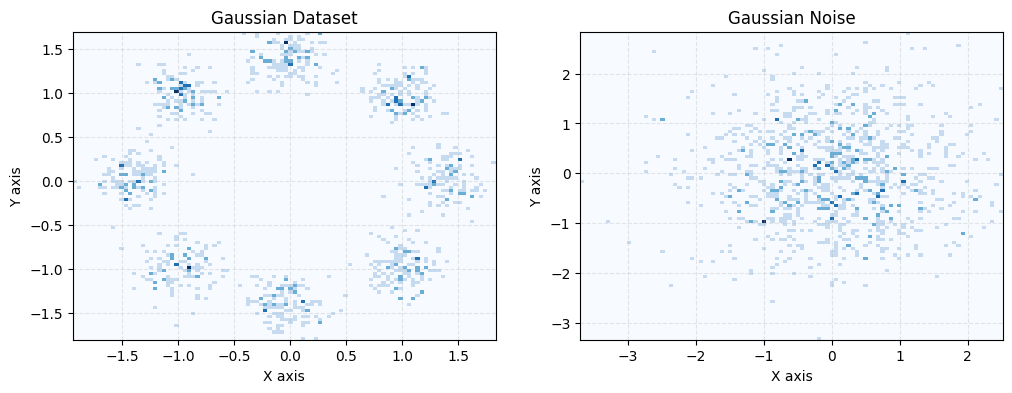

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_samples = 1000

def generate_gaussian_dataset(n_samples) -> np.ndarray:

    N = 8
    radius = 4
    centers = torch.linspace(0, 2 * torch.pi * (N + 1), (N + 1))[:-1]
    centers = torch.stack([radius * torch.cos(centers), radius * torch.sin(centers)], dim = 1)
    # Sample centers N times randomly
    centers = centers[torch.randint(len(centers), size=(n_samples,))]

    # Generate random samples with normal distribution
    Z = torch.randn(n_samples, 2) * 0.5

    # Scale to normalize std of Z to ~ 1.0 and is similar to noise distr.
    scale = 1 / torch.sqrt(centers.std() ** 2 + Z.std() ** 2)
    samples = scale * (Z + centers)

    # Convert to numpy for plotting
    return samples.numpy()


def generate_gaussian_noise(n_samples) -> np.ndarray:
    return torch.randn(n_samples, 2)

gaussian_dataset = generate_gaussian_dataset(n_samples)
gaussian_noise = generate_gaussian_noise(n_samples)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
hist_kwargs = {'bins': 100, "cmap": "Blues"}

# Gaussian Dataset
axs[0].hist2d(x=gaussian_dataset[:, 0], y=gaussian_dataset[:, 1], **hist_kwargs)
axs[0].set_title('Gaussian Dataset')
axs[0].set_xlabel('X axis')
axs[0].set_ylabel('Y axis')
axs[0].grid(True, linestyle='--', alpha=0.3)

# Gaussian Noise - heatmap
axs[1].hist2d(x=gaussian_noise[:, 0], y=gaussian_noise[:, 1], **hist_kwargs)
axs[1].set_title('Gaussian Noise')
axs[1].set_xlabel('X axis')
axs[1].set_ylabel('Y axis')
axs[1].grid(True, linestyle='--', alpha=0.3)

plt.show()


              std           mean
noise  0.96719974  -0.0019822747
data     0.999721        0.00995

Here are both distributiosn stacked:



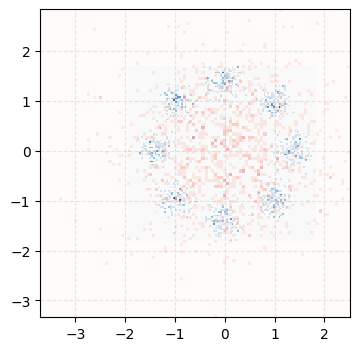

In [11]:
import pandas as pd

data_info = pd.DataFrame(
    columns = ["std", "mean"], 
    index = ["noise", "data"],
    data=[[gaussian_noise.std().numpy(), gaussian_noise.mean().numpy()],
        [gaussian_dataset.std(), gaussian_dataset.mean()]])

text = f"""
{data_info}

Here are both distributiosn stacked:
"""
print(text)

fig, ax = plt.subplots(figsize=(4, 4))

hist_kwargs = {'bins': 100, "cmap": "Blues"}
hist1 = ax.hist2d(gaussian_dataset[:, 0], gaussian_dataset[:, 1], **hist_kwargs)
hist_kwargs = {'bins': 100, 'cmap': 'Reds', 'alpha': 0.3}
hist2 = ax.hist2d(gaussian_noise[:, 0], gaussian_noise[:, 1], **hist_kwargs)

ax.grid(True, linestyle='--', alpha=0.3)
plt.show()

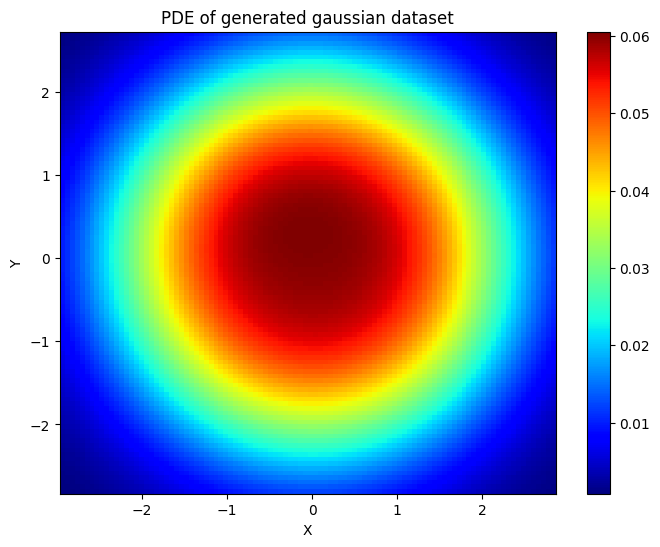

In [31]:
def gaussian_kde_2d(data, bandwidth):
    assert len(data.shape) == 2, "Should be 2-d array"
    assert data.shape[1] > 1, ""

    data_x, data_y = data[:, 0], data[:, 1]

    # Define the grid where we want to estimate the density
    x_grid = np.linspace(data_x.min() - 1, data_x.max() + 1, 100)
    y_grid = np.linspace(data_y.min() - 1, data_y.max() + 1, 100)

    n = len(data_x)
    density = np.zeros((len(y_grid), len(x_grid)))

    for i in range(n):
        kernel_x = np.exp(-0.5 * ((x_grid - data_x[i]) / bandwidth) ** 2) / (bandwidth * np.sqrt(2 * np.pi))
        kernel_y = np.exp(-0.5 * ((y_grid - data_y[i]) / bandwidth) ** 2) / (bandwidth * np.sqrt(2 * np.pi))
        density += np.outer(kernel_y, kernel_x)

    density /= n
    return density, x_grid, y_grid


# Perform manual Gaussian KDE for 2D data
bandwidth = 1
density, x_grid, y_grid = gaussian_kde_2d(gaussian_dataset,  bandwidth)

# Get the meshgrid for plotting
X, Y = np.meshgrid(x_grid, y_grid)

# Plot using pcolormesh to show the density
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, density, shading='auto', cmap='jet')
plt.colorbar()
plt.title('PDE of generated gaussian dataset')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()